## Clustering Evaluation

### All imports here

In [106]:
import json
import numpy as np
from collections import Counter
from sklearn import metrics
from scipy.spatial import distance

In [107]:
import matplotlib.pyplot as plt
%matplotlib inline

### Functions

In [122]:
def parse_distance_matrix(pic_matrix_json):
    """
    parse distance matrix output from pic clustering algorithm
    @arg pic_matrix_json json file containing pic clustering distance
    @return distance dictionary and set of pois
    """
    distance_dict, pois = {}, set()
    for item in pic_matrix_json:
        pois.add(item['poi1'])
        pois.add(item['poi2'])
        if item['poi1'] not in distance_dict.keys():
            distance_dict[item['poi1']] = {item['poi2']: item['distance']}
        else:
            distance_dict[item['poi1']][item['poi2']] = item['distance']
    return distance_dict, pois

def build_distance_matrix(distance_dict, pois):
    """
    build distance matrix from distance dictionary and set of pois, key error should never be thrown here
    @distance_dict contains pairs distance between poi_i and poi_j without duplications, considering (poi_i, poi_j) and (poi_j, poi_i) duplicated
    @pois a list of pois
    @return distance matrix with row sequentially equal to elements in pois
    """
    matrix = []
    for poi_i in pois:  # each row
        row = []
        for poi_j in pois:  # each column
            if poi_i == poi_j:  # if poi_i and poi_j is the same
                row.append(0.0)
            elif poi_i in distance_dict.keys():  # if there is relation between poi_i and poi_j
                if poi_j in distance_dict[poi_i].keys():
                    row.append(distance_dict[poi_i][poi_j])
                else:
                    row.append(distance_dict[poi_j][poi_i])
            else:  # if there is no relation between poi_i and poi_j
                row.append(1.0)
        matrix.append(np.array(row))
    return np.array(matrix)

def parse_clustering_result(clusters_json):
    """
    parse clustering result to get cluster id and corresponding pois in cluster
    """
    clusters = {}
    for cluster in clusters_json['clusters']:
        if cluster['cluster_id'] not in clusters:
            clusters[cluster['cluster_id']] = []
        for poi in cluster['poi_in_cluster']:
            clusters[cluster['cluster_id']].append((poi['poi_id'], poi['categories']['categories']))
    return clusters

def build_label(clusters, pois):
    """
    get cluster label for each poi from clusters and pois
    """
    poi_cluster_label = {}
    for key, value in clusters.items():  # for each cluster_i and pois_in_cluster_i
        for poi in value:  # for each poi(id, categories) in cluster_i
            assert poi[0] not in poi_cluster_label.keys()  # poi shouldn't be labeled, poi assigned to one cluster only
            poi_cluster_label[poi[0]] = key
    
    labels = []
    for poi in pois:  # get cluster label for each poi from poi_cluster dict
        labels.append(poi_cluster_label[poi])
    return np.array(labels)

def build_mds_distance_matrix(poi_coordinates, pois):
    """
    build distance matrix from mds coordinates, so far 2-dimensional space
    """
    mds_matrix = []
    for poi_i in pois:
        row = []
        for poi_j in pois:
            if poi_i == poi_j:
                row.append(0)
            else:
                row.append(distance.euclidean(poi_coordinates[poi_i], poi_coordinates[poi_j]))
        mds_matrix.append(row)
    return np.array(mds_matrix)

def cal_purity(num_pois, clusters):
    """
    calculate purity of clustering result
    """
    num_common = 0
    # for cluster in clusters
    for i, clu in enumerate(clusters):
        new_cluster = []
        # for poi in cluster
        for j, poi in enumerate(clusters[i]):
            #clusters[i][j] = ' '.join(sorted(poi[1]))
            new_cluster.append(' '.join(sorted(poi[1])))  # cluster with each poi in one combined category
        num_common += Counter(new_cluster).most_common(1)[0][1]  # add the number of most common category in each cluster
    return num_common / num_pois

def cal_nmi(num_pois, clusters):
    print('Number of clusters: ', len(clusters))
    categories = {}
    categories_in_clusters = []
    for i, cluster in enumerate(clusters):
        categories_in_cluster = {}
        for j, poi in enumerate(word2vec_clusters[i]):
            category = ' '.join(sorted(poi[1]))
            if category not in categories.keys():
                categories[category] = 1
            else:
                categories[category] += 1

            if category not in categories_in_cluster.keys():
                categories_in_cluster[category] = 1
            else:
                categories_in_cluster[category] += 1
        categories_in_clusters.append(categories_in_cluster)
        print('Number of categories: ', len(categories_in_cluster), ' in cluster ', i)
    print('Number of categories: ', len(categories))
    
    mutual_info = 0
    for i, categories_in_cluster in enumerate(categories_in_clusters):
        w_i_card = len(clusters[i])
        for category, c_j_card in categories.items():
            if category in categories_in_cluster.keys():
                intersect_w_c = categories_in_cluster[category]
                mutual_info += intersect_w_c / num_pois * np.log( (num_pois * intersect_w_c) / (w_i_card * c_j_card) )
    
    h_omega = 0.0
    for i, cluster in enumerate(word2vec_clusters):
        temp_v = len(clusters[i]) / num_pois
        h_omega += temp_v * np.log(temp_v)
    h_omega = 0.0 - h_omega
    print('Entropy of cluster: ', h_omega)
    
    h_c = 0.0
    for category, c_j_card in categories.items():
        temp_v = c_j_card / num_pois
        h_c += temp_v * np.log(temp_v)
    h_c = 0.0 - h_c
    print('Entropy of classes: ', h_c)
    
    nmi = mutual_info / ((h_omega + h_c) / 2)
    return nmi

### PIC

#### silhouette score

In [123]:
with open('../../results/pic_matrix.json') as pic_matrix:
    pic_matrix_json = json.load(pic_matrix)

# get the distance between pois(poi_1, poi_2) and poi_ids(poi_1, poi_2, poi_3, ...)
distance_dict, pois = parse_distance_matrix(pic_matrix_json)

# distance matrix with rows equal to poi in pois sequentially
matrix = build_distance_matrix(distance_dict, pois)

with open('../../results/pic_clusters.json') as pic_clusters:
    pic_clusters_json = json.load(pic_clusters)

# a list of clusters, each cluster containing a list of (poi_id, categories) in the cluster
pic_clusters = parse_clustering_result(pic_clusters_json)

# get the cluster id for each poi in pois get from parse_distance_matrix
labels = build_label(pic_clusters, pois)

pic_silhouette_score = metrics.silhouette_score(matrix, labels, metric='precomputed')
print('pic silhouette score: ', pic_silhouette_score)

pic silhouette score:  0.32597595993289535


#### purity

$$ purity(\Omega, C) = \frac{1}{n} \sum_{k} \max_{j} |\omega_{k} \bigcap c_{j}| $$
$$ \Omega = {\omega_1, \omega_2, ...., \omega_k} $$
$$ C = {c_1, c_2, ..., c_j} $$

In [124]:
num_pois = len(pois)
pic_purity = cal_purity(num_pois, pic_clusters)
print('pic purity: ', pic_purity)

pic purity:  0.336026936026936


#### normalized mutual information

$$ I(\Omega;C) = \sum_{k}\sum_{j}P(\omega_k \cap c_j) log \frac{P(\omega_k \cap c_j)}{P(\omega_k)P(c_j)}$$

$$= \sum_{k}\sum_{j}\frac{|\omega_k \cap c_j|}{N} log \frac{N |\omega_k \cap c_j|}{|\omega_k||c_j|}$$,

$$ H(\Omega) = - \sum_{k} P(\omega_k)logP(\omega_k) $$

$$ = - \sum_{k} \frac{|\omega_k|}{N} log \frac{|\omega_k|}{N}$$

$$ NMI(\Omega, C) = \frac{I(\Omega;C)}{[H(\Omega) + H(C)]/2} $$

In [125]:
pic_nmi = cal_nmi(num_pois, pic_clusters)
print('pic nmi: ', pic_nmi)

Number of clusters:  10
Number of categories:  175  in cluster  0
Number of categories:  10  in cluster  1
Number of categories:  74  in cluster  2
Number of categories:  51  in cluster  3
Number of categories:  76  in cluster  4
Number of categories:  22  in cluster  5
Number of categories:  82  in cluster  6
Number of categories:  6  in cluster  7
Number of categories:  31  in cluster  8
Number of categories:  34  in cluster  9
Number of categories:  561
Entropy of cluster:  1.9571485303409726
Entropy of classes:  5.023124030478338
pic nmi:  0.6532647234878042


### MDS

#### silhouette score

In [126]:
with open('../../results/mds_coordinates.json') as mds_coordinates:
    mds_coordinates_json = json.load(mds_coordinates)

poi_coordinates = {}
for item in mds_coordinates_json['coordinates']:
    poi_coordinates[item['poiID']] = (item['coordinate'][0], item['coordinate'][1])

mds_matrix = build_mds_distance_matrix(poi_coordinates, pois)
with open('../../results/mds_kmeans_clusters.json') as mds_kmeans_clusters:
    mds_kmeans_clusters_json = json.load(mds_kmeans_clusters)

mds_clusters = parse_clustering_result(mds_kmeans_clusters_json)
mds_labels = build_label(mds_clusters, pois)

mds_silhouette_score = metrics.silhouette_score(mds_matrix, mds_labels, metric='precomputed')
print('mds silhouette score: ', mds_silhouette_score)

mds silhouette score:  0.8456986105658925


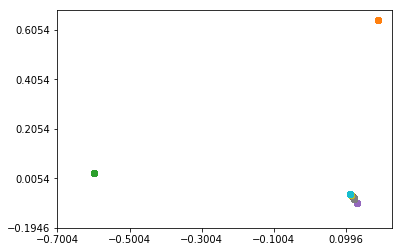

In [127]:
mds_clusters_coordinate = {}
for key, values in mds_clusters.items():
    if key not in mds_clusters_coordinate.keys():
        mds_clusters_coordinate[key] = {'x': [], 'y': []}
    for value in values:
        mds_clusters_coordinate[key]['x'].append(poi_coordinates[value[0]][0])
        mds_clusters_coordinate[key]['y'].append(poi_coordinates[value[0]][1])

NUM_COLORS = len(mds_clusters_coordinate)
fig = plt.figure()  # figsize=(12,12)
ax = fig.add_subplot(111)
min_x, max_x, min_y, max_y = None, None, None, None
for i in range(NUM_COLORS):
    if min_x is None or min_x > min(mds_clusters_coordinate[i]['x']):
        min_x = min(mds_clusters_coordinate[i]['x'])
    if max_x is None or max_x < max(mds_clusters_coordinate[i]['x']):
        max_x = max(mds_clusters_coordinate[i]['x'])
    if min_y is None or min_y > min(mds_clusters_coordinate[i]['y']):
        min_y = min(mds_clusters_coordinate[i]['y'])
    if max_y is None or max_y < max(mds_clusters_coordinate[i]['y']):
        max_y = max(mds_clusters_coordinate[i]['y'])
    ax.scatter(mds_clusters_coordinate[i]['x'], mds_clusters_coordinate[i]['y'])
plt.xticks(np.arange(min_x-0.1, max_x+0.1, step=0.2))
plt.yticks(np.arange(min_y-0.1, max_y+0.1, step=0.2))
plt.show()

#### purity 

In [128]:
num_pois = len(pois)
mds_purity = cal_purity(num_pois, mds_clusters)
print('mds purity: ', mds_purity)

mds purity:  0.3367003367003367


#### normalized mutual information

In [129]:
mds_nmi = cal_nmi(num_pois, mds_clusters)
print('mds nmi: ', mds_nmi)

Number of clusters:  10
Number of categories:  175  in cluster  0
Number of categories:  10  in cluster  1
Number of categories:  74  in cluster  2
Number of categories:  51  in cluster  3
Number of categories:  76  in cluster  4
Number of categories:  22  in cluster  5
Number of categories:  82  in cluster  6
Number of categories:  6  in cluster  7
Number of categories:  31  in cluster  8
Number of categories:  34  in cluster  9
Number of categories:  561
Entropy of cluster:  2.045928263760873
Entropy of classes:  5.023124030478338
mds nmi:  0.6615206525687137


### OneHot Encoding

#### silhouette score

In [130]:
with open('../../results/oneHotMatrix.json') as one_hot:
    one_hot_encoded = json.load(one_hot)

poi_encoding = {}
for item in one_hot_encoded:
    poi_encoding[item[0]] = item[1:]

with open('../../results/oneHot_kmeans_clusters.json') as onehot_kmeans_clusters:
    onehot_kmeans_clusters_json = json.load(onehot_kmeans_clusters)

onehot_matrix, poi_new = [], []
for poi_i, poi_i_code in poi_encoding.items():
    poi_new.append(poi_i)
    row = []
    for poi_j, poi_j_code in poi_encoding.items():
        if poi_i == poi_j:
            row.append(0)
        else:
            row.append(distance.euclidean(poi_i_code, poi_j_code))
    onehot_matrix.append(row)
onehot_matrix = np.array(onehot_matrix)

onehot_clusters = parse_clustering_result(onehot_kmeans_clusters_json)
onehot_labels = build_label(onehot_clusters, poi_new)
onehot_silhouette_score = metrics.silhouette_score(onehot_matrix, onehot_labels, metric='precomputed')
print('one hot silhouette score: ', onehot_silhouette_score)

one hot silhouette score:  0.3053573841536867


#### purity

In [131]:
num_pois = len(pois)
onehot_purity = cal_purity(num_pois, onehot_clusters)
print('one hot purity: ', onehot_purity)

one hot purity:  0.3218855218855219


#### normalized mutual information

In [132]:
onehot_nmi = cal_nmi(num_pois, onehot_clusters)
print('one hot nmi: ', onehot_nmi)

Number of clusters:  10
Number of categories:  175  in cluster  0
Number of categories:  10  in cluster  1
Number of categories:  74  in cluster  2
Number of categories:  51  in cluster  3
Number of categories:  76  in cluster  4
Number of categories:  22  in cluster  5
Number of categories:  82  in cluster  6
Number of categories:  6  in cluster  7
Number of categories:  31  in cluster  8
Number of categories:  34  in cluster  9
Number of categories:  561
Entropy of cluster:  1.740149951533934
Entropy of classes:  5.023124030478338
one hot nmi:  0.7173219522024794


### Word2Vec

#### silhouette score

In [133]:
with open('../../results/word2Vec.json') as word2Vec:
    word_vec_encoded = json.load(word2Vec)
    
word_vec_dict = {}
for word_vec in word_vec_encoded:
    word_vec_dict[word_vec['_1']] = word_vec['_2']
    
with open('../../results/word2vec_kmeans_clusters.json') as word2vec_kmeans_clusters:
    word2vec_kmeans_clusters_json = json.load(word2vec_kmeans_clusters)
    
word2vec_clusters = parse_clustering_result(word2vec_kmeans_clusters_json)

word2vec_matrix, poi_word2vec = [], []
for poi_i, poi_i_code in word_vec_dict.items():
    poi_word2vec.append(poi_i)
    row = []
    for poi_j, poi_j_code in word_vec_dict.items():
        if poi_i == poi_j:
            row.append(0)
        else:
            row.append(distance.euclidean(poi_i_code, poi_j_code))
    word2vec_matrix.append(row)
word2vec_matrix = np.array(word2vec_matrix)

word2vec_labels = build_label(word2vec_clusters, poi_word2vec)
word2vec_silhouette_score = metrics.silhouette_score(word2vec_matrix, word2vec_labels, metric='precomputed')
print('word2vec silhouette score: ', word2vec_silhouette_score)

word2vec silhouette score:  0.5559534610129746


#### purity

In [134]:
num_pois = len(pois)
word2vec_purity = cal_purity(num_pois, word2vec_clusters)
print('Word2Vec purity: ', word2vec_purity)

Word2Vec purity:  0.3441077441077441


#### normalized mutual information

In [135]:
word2vec_nmi = cal_nmi(num_pois, word2vec_clusters)
print('word2vec nmi: ', word2vec_nmi)

Number of clusters:  10
Number of categories:  175  in cluster  0
Number of categories:  10  in cluster  1
Number of categories:  74  in cluster  2
Number of categories:  51  in cluster  3
Number of categories:  76  in cluster  4
Number of categories:  22  in cluster  5
Number of categories:  82  in cluster  6
Number of categories:  6  in cluster  7
Number of categories:  31  in cluster  8
Number of categories:  34  in cluster  9
Number of categories:  561
Entropy of cluster:  2.028214379527824
Entropy of classes:  5.023124030478338
word2vec nmi:  0.5752707533224323
